# 8 Modtran File Processing

This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  


[<img src="https://zenodo.org/badge/doi/10.5281/zenodo.9910.png"   align="left"/>](http://dx.doi.org/10.5281/zenodo.9910)


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

The pyradi library has a module to handle Modtran files.  The module currently has only one function: to read Modtran tape7 files in an intelligent manner.  The function is [`rymodtran.loadtape7`](http://nelisw.github.io/pyradi-docs/_build/html/rymodtran.html#pyradi.rymodtran.loadtape7).

In [2]:
%matplotlib inline
import numpy as np
import pyradi.ryfiles as ryfiles
import pyradi.ryplot as ryplot
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

import matplotlib as mpl
mpl.rc("savefig", dpi=300)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

# import pandas as pd
# pd.set_option('display.max_columns', 80)
# pd.set_option('display.width', 100)
# pd.set_option('display.max_colwidth', 150)

## Loading Tape7 Files


This function reads in the tape7 file from MODerate spectral resolution atmospheric TRANsmission ([MODTRAN](http://modtran5.com/)) code, that is used to model the propagation of the electromagnetic radiation through the atmosphere. tape7 is a primary file that contains all the spectral results of the MODTRAN run. The header information in the tape7 file contains portions of the tape5 information that is ignored here. The header section in tape7 is followed by a list of spectral samples with corresponding transmissions. Each column has a different component of the transmission or radiance. For more detail, see the Modtran documentation.

The user selects the appropriate columns by listing the column names, as
listed below. The tape7.scn file has missing columns, so this function does not work for tape7.scn files.  If you need a tape7.scn file with all the columns populated
you would have to use the regular tape7 file and convolve this to lower resolution.

The format of the tape7 file changes for different IEMSCT values. For
the most part the differences are hidden in the details, if the columns are read by column header and not by counting columns.  The various column headers used in the tape7 file are as follows:

**IEMSCT = 0** has two lines of column headers.  In order to select the column, you
must concatenate the two column headers with an underscore in between. All
columns are available with the following column names:   
[`FREQ_CM-1`, `COMBIN_TRANS`, `H2O_TRANS`, `UMIX_TRANS`, `O3_TRANS`, `TRACE_TRANS`,
`N2_CONT`, `H2O_CONT`, `MOLEC_SCAT`, `AER+CLD_TRANS`, `HNO3_TRANS`,
`AER+CLD_abTRNS`, `-LOG_COMBIN`, `CO2_TRANS`, `CO_TRANS`, `CH4_TRANS`,
`N2O_TRANS`, `O2_TRANS`, `NH3_TRANS`, `NO_TRANS`, `NO2_TRANS`,
`SO2_TRANS`, `CLOUD_TRANS`, `CFC11_TRANS`, `CFC12_TRANS`, `CFC13_TRANS`,
`CFC14_TRANS`, `CFC22_TRANS`, `CFC113_TRANS`, `CFC114_TRANS`,
`CFC115_TRANS`, `CLONO2_TRANS`, `HNO4_TRANS`, `CHCL2F_TRANS`,
`CCL4_TRANS`,  `N2O5_TRANS`]

**IEMSCT = 1** has single line of column headers. A number of columns have
headers, but with no column numeric data.  In the following list the
columns with header names `**` are empty in some runs:  
[`FREQ`,
`TOT_TRANS`, `PTH_THRML`, `THRML_SCT`, `SURF_EMIS`, `*SOL_SCAT*`,
`*SING_SCAT*`, `GRND_RFLT`, `*DRCT_RFLT*`, `TOTAL_RAD`, `*REF_SOL*`, `*SOL@OBS*`,
`DEPTH`, `DIR_EM`, `*TOA_SUN*`, `BBODY_T[K]`].  
Hence, these columns may not
have valid data: [`SOL_SCAT`, `SING_SCAT`, `DRCT_RFLT`, `REF_SOL`,
`SOL@OBS`, `TOA_SUN`]


**IEMSCT = 2** has a single line column headers. All the columns are available:  
[`FREQ`, `TOT_TRANS`, `PTH_THRML`, `THRML_SCT`, `SURF_EMIS`, `SOL_SCAT`,
`SING_SCAT`, `GRND_RFLT`, `DRCT_RFLT`, `TOTAL_RAD`, `REF_SOL`, `SOL@OBS`,
`DEPTH`, `DIR_EM`, `TOA_SUN`, `BBODY_T[K]`]


**IEMSCT = 3** has a single line column headers.  One of these seems to be two
words, which, in this code must be concatenated with an underscore. There
is also  additional column (assumed to be depth in this code).  The
columns available are  
[`FREQ`, `TRANS`, `SOL_TR`, `SOLAR`, `DEPTH`]


## Modtran Tape7 Reader Examples

First prepare by importing and downloading the tape7 files from the internet.

In [3]:


tgzFilename = 'modtrandata.tgz'
destinationDir = '.'
tarFilename = 'modtrandata.tar'
url = 'https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/'
dlNames = ryfiles.downloadUntar(tgzFilename, url, destinationDir, tarFilename)

print('filesAvailable are {}'.format(dlNames))

filesAvailable are ['horizon5kmtropical.fl7', 'NIRscat.fl7', 'tape7-01', 'tape7-02', 'tape7-02b', 'tape7-03', 'tape7-03b', 'tape7-04', 'tape7-05', 'tape7-05b', 'tape7VISNIR5kmTrop23Vis']


The function [`rymodtran.loadtape7`](http://nelisw.github.io/pyradi-docs/_build/html/rymodtran.html#pyradi.rymodtran.loadtape7) is relatively easy to use, with only two parameters: the filename and the specification of which columns to read (a list). In some instances (`IEMSCT == 0`) the column header is given over two lines, and your specification must include the information on both lines. This is done by concatenating the two parts with an underscore character as in `TRACE` and `TRANS` becoming `TRACE_TRANS`.

**IEMSCT = 0**: this example loads data from five columns. Note the underscore to indicate that the column header flows over two lines.

In [4]:
tape7 = rymodtran.loadtape7("tape7-01", ['FREQ_CM-1', 'COMBIN_TRANS', 
                                         'MOLEC_SCAT', 'AER+CLD_TRANS', 
                                         'AER+CLD_abTRNS'] )
print(tape7.shape)

(51L, 5L)


The next example reads all the columns in the tape7 file:

In [5]:
tape7 = rymodtran.loadtape7("tape7-01", ['FREQ_CM-1', 'COMBIN_TRANS', 
                                         'H2O_TRANS', 'UMIX_TRANS', 
                                         'O3_TRANS', 'TRACE_TRANS', 
                                         'N2_CONT', 'H2O_CONT', 'MOLEC_SCAT',
                                         'AER+CLD_TRANS', 'HNO3_TRANS',
                                         'AER+CLD_abTRNS', '-LOG_COMBIN', 
                                         'CO2_TRANS', 'CO_TRANS', 'CH4_TRANS',
                                         'N2O_TRANS', 'O2_TRANS', 'NH3_TRANS',
                                         'NO_TRANS', 'NO2_TRANS', 'SO2_TRANS',
                                         'CLOUD_TRANS', 'CFC11_TRANS', 
                                         'CFC12_TRANS', 'CFC13_TRANS', 
                                         'CFC14_TRANS', 'CFC22_TRANS', 
                                         'CFC113_TRANS', 'CFC114_TRANS', 
                                         'CFC115_TRANS', 'CLONO2_TRANS', 
                                         'HNO4_TRANS', 'CHCL2F_TRANS', 
                                         'CCL4_TRANS', 'N2O5_TRANS'] )
print(tape7.shape)

(51L, 36L)


**IEMSCT = 1**: this example loads data from all columns with data in the sample file.

In [6]:
tape7 = rymodtran.loadtape7("tape7-02", ['FREQ', 'TOT_TRANS', 'PTH_THRML', 
                                         'THRML_SCT', 'SURF_EMIS', 
                                         'GRND_RFLT', 'TOTAL_RAD', 'DEPTH', 
                                         'DIR_EM', 'BBODY_T[K]'] )
print(tape7.shape)

(51L, 10L)


**IEMSCT = 2**: this example loads data from all columns  in the sample file.

In [7]:
tape7 = rymodtran.loadtape7("tape7-03", ['FREQ', 'TOT_TRANS', 'PTH_THRML', 
                                         'THRML_SCT', 'SURF_EMIS', 'SOL_SCAT',
                                         'SING_SCAT', 'GRND_RFLT', 
                                         'DRCT_RFLT', 'TOTAL_RAD', 'REF_SOL',
                                         'SOL@OBS', 'DEPTH', 'DIR_EM', 
                                         'TOA_SUN', 'BBODY_T[K]'] )
print(tape7.shape)

(51L, 16L)


**IEMSCT = 3**: this example loads data from all columns with data in the sample file. Note that in the data file the the fifth column is not labelled, but the function reads still it.

In [8]:
tape7 = rymodtran.loadtape7("tape7-04", ['FREQ', 'TRANS', 'SOL_TR', 
                                         'SOLAR', 'DEPTH'] )
print(tape7.shape)

(101L, 5L)


The next example reads data from the file and display the data in a plot. The columns to be read and plotted are defined in the list `colSelect`. This list is used when loading the data, but also as legend in the plot.  The Modtran data is given in wavenumber domain. The plot must be in wavelength domain, hence wavenumber is converted to wavelength using [`ryutils.convertSpectralDomain`](http://nelisw.github.io/pyradi-docs/_build/html/ryutils.html#pyradi.ryutils.convertSpectralDomain). Finally, the various transmittance curves are plotted against wavelength.

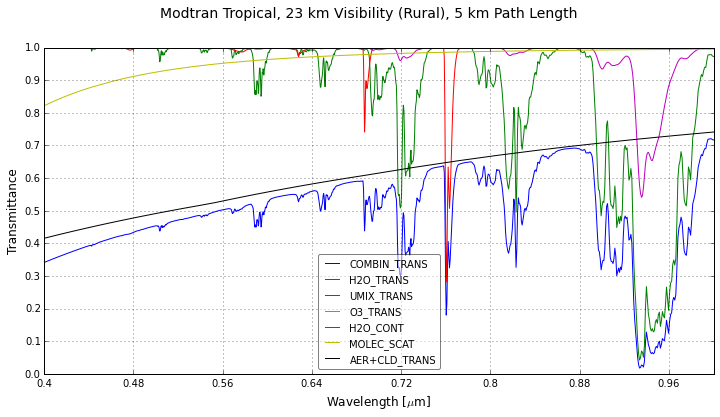

In [9]:
colSelect =  ['FREQ_CM-1', 'COMBIN_TRANS', 'H2O_TRANS', 'UMIX_TRANS',
              'O3_TRANS', 'H2O_CONT', 'MOLEC_SCAT', 'AER+CLD_TRANS']
tape7= rymodtran.loadtape7("tape7VISNIR5kmTrop23Vis", colSelect )
wavelen = ryutils.convertSpectralDomain(tape7[:,0],  type='nl')
mT = ryplot.Plotter(1, 1, 1,"Modtran Tropical, 23 km Visibility (Rural)"
                   + ", 5 km Path Length",figsize=(12,6))
mT.plot(1, wavelen, tape7[:,1:], "","Wavelength [$\mu$m]", "Transmittance",
       label=colSelect[1:],legendAlpha=0.5, pltaxis=[0.4,1, 0, 1])


The next example plots the transmittance from the individual molecules and aerosol separately to clearly show the effect of each.

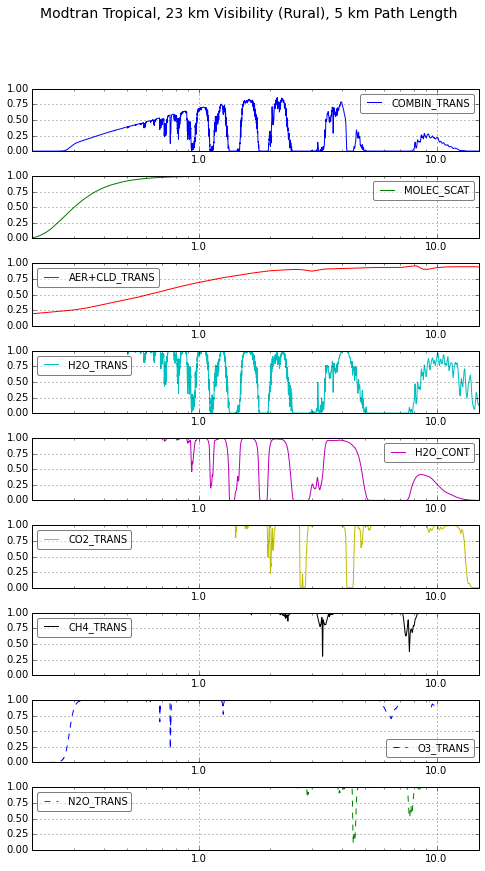

In [10]:
# this example plots the individual transmittance components
colSelect =  ['FREQ_CM-1', 'COMBIN_TRANS', 'MOLEC_SCAT', 'CO2_TRANS', 
              'H2O_TRANS', 'H2O_CONT', 'CH4_TRANS', 'O3_TRANS', 'O2_TRANS', 
              'N2O_TRANS', 'AER+CLD_TRANS', 'SO2_TRANS']
tape7= rymodtran.loadtape7("horizon5kmtropical.fl7", colSelect )
wavelen = ryutils.convertSpectralDomain(tape7[:,0],  type='nl')
mT = ryplot.Plotter(1, 9, 1,"Modtran Tropical, 23 km Visibility (Rural)"\
                   + ", 5 km Path Length",figsize=(8,14))
mT.semilogX(1, wavelen, tape7[:,1], '','', '', maxNY=4,
       label=colSelect[1:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(2, wavelen, tape7[:,2], '','', '', maxNY=4,
       label=colSelect[2:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(3, wavelen, tape7[:,10], '','', '', maxNY=4,
       label=colSelect[10:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(4, wavelen, tape7[:,4] , '','', '', maxNY=4,
       label=colSelect[4:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(5, wavelen, tape7[:,5] , '','', '', maxNY=4,
       label=colSelect[5:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(6, wavelen, tape7[:,3]  , '','', '', maxNY=4,
       label=colSelect[3:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(7, wavelen, tape7[:,6]  , '','', '', maxNY=4,
       label=colSelect[6:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(8, wavelen, tape7[:,7] * tape7[:,8] , '','', '', maxNY=4,
       label=colSelect[7:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);
mT.semilogX(9, wavelen, tape7[:,9]  , '','', '', maxNY=4,
       label=colSelect[9:],legendAlpha=0.5, pltaxis=[0.2,15, 0, 1]);


The final example reads path radiance data from a file, plots the results, and calculates the total path radiance in a spectral band.  In this example the plot and integration are done in wavenumber domain. Normally you would multiply with a sensor spectral response before integration, but this calculation is over the whole band, equally weighted.

Modtran's path radiance is given in units of W/(cm$^2$.sr) and must ideally be converted to units of W/(m$^2$.sr). This is not a critical conversion, but my preference is to work in base units such as metres.

PTH_THRML integral is 9.4787611806e-18 [W/(m^2.sr)]
SOL_SCAT integral is 0.605931118 [W/(m^2.sr)]
SING_SCAT integral is 0.529447243 [W/(m^2.sr)]
TOTAL_RAD integral is 0.605931118 [W/(m^2.sr)]
Note that multiple scatter contributes significantly to total path radiance


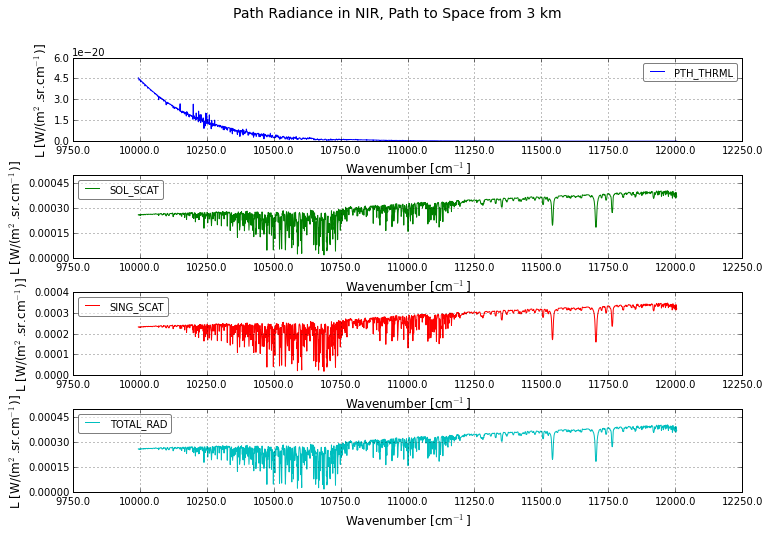

In [11]:
colSelect =  ['FREQ', 'PTH_THRML','SOL_SCAT','SING_SCAT', 'TOTAL_RAD']
skyrad= rymodtran.loadtape7("NIRscat.fl7", colSelect )
sr = ryplot.Plotter(1, 4,1,"Path Radiance in NIR, Path to Space from 3 km",
                    figsize=(12,8))
# plot the components separately
for i in [1,2,3,4]:
  Lpath = 1.0e4 * skyrad[:,i]
  sr.plot(i,  skyrad[:,0], Lpath, "","Wavenumber [cm$^{-1}$]",
          "L [W/(m$^2$.sr.cm$^{-1}$)]",
         label=[colSelect[i][:]],legendAlpha=0.5, #pltaxis=[0.4,1, 0, 1],
         maxNX=10, maxNY=4, powerLimits = [-4,  4, -5, 5])

  #convert from /cm^2 to /m2 and integrate using the wavenumber vector
  totinband = np.trapz(Lpath.reshape(-1, 1),skyrad[:,0], 
                                  axis=0)[0]
  print('{0} integral is {1} [W/(m^2.sr)]'.format(colSelect[i][:],totinband))

print('Note that multiple scatter contributes significantly' + \
      ' to total path radiance')

Repeat the previous example, but this time plot and integrate in the wavelength domain. The integrated results should be the same as for the example above.  In this example the wavenumber domain is converted to wavelength domain and the spectral densities are likewise converted.

Note that the domain and densities are simply converted, not resampled. This means that the data is still at constant wavenumber intervals (varying wavelength intervals). This does not pose a problem when plotting, but care must be taken when integrating to tell `trapz` that the x interval is not constant. Note, however that the data is in a sequence of *increasing* wavenumber; that means *decreasing* wavelength, and as a result the integral is negative (negative integration intervals).

PTH_THRML integral is 9.47875899768e-18 [W/(m^2.sr)]
SOL_SCAT integral is 0.605931125407 [W/(m^2.sr)]
SING_SCAT integral is 0.529447248986 [W/(m^2.sr)]
TOTAL_RAD integral is 0.605931125407 [W/(m^2.sr)]
Note that multiple scatter contributes significantly to total path radiance


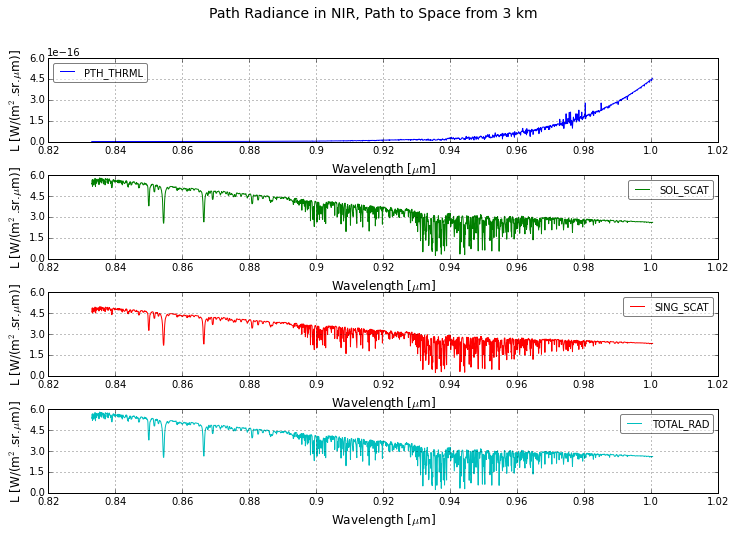

In [12]:
colSelect =  ['FREQ', 'PTH_THRML','SOL_SCAT','SING_SCAT', 'TOTAL_RAD']
skyrad= rymodtran.loadtape7("NIRscat.fl7", colSelect )
sr = ryplot.Plotter(1, 4,1,"Path Radiance in NIR, Path to Space from 3 km",
                    figsize=(12,8))

# plot the components separately
for i in [1,2,3,4]:
  wl, Lpath = ryutils.convertSpectralDensity(skyrad[:,0],
                                                     skyrad[:,i],'nl')
  Lpath *= 1.0e4
  sr.plot(i,  wl, Lpath, "","Wavelength [$\mu$m]",
          "L [W/(m$^2$.sr.$\mu$m)]",
         label=[colSelect[i][:]],legendAlpha=0.5, #pltaxis=[0.4,1, 0, 1],
         maxNX=10, maxNY=4, powerLimits = [-4,  4, -5, 5])

  #convert from /cm^2 to /m2 and integrate using the wavenumber vector
  totinband = - np.trapz(Lpath.reshape(-1, 1),wl, 
                                  axis=0)[0]
  print('{0} integral is {1} [W/(m^2.sr)]'.format(colSelect[i][:],totinband))

print('Note that multiple scatter contributes significantly' + \
      ' to total path radiance')

## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [13]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, pyradi

Software versions
Python 2.7.10 64bit [MSC v.1500 64 bit (AMD64)]
IPython 4.0.0
OS Windows 7 6.1.7601 SP1
numpy 1.10.1
scipy 0.16.0
matplotlib 1.4.3
pyradi 0.2.1
Thu Dec 10 07:32:16 2015 South Africa Standard Time